In [62]:
%load_ext autoreload
%autoreload 2

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import *    
import os 
import pyreadr
import numpy as np
import pyreadr
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
import butterfly.album
import butterfly.CNN
from itertools import combinations 
from joblib import parallel_backend
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import r2_score
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
#Import your data
DF = pyreadr.read_r('/Users/mxenoc/Desktop/workspace/butterfly/data/omics.RData')
#DF = pyreadr.read_r('/home/mxenoc/workspace/butterfly/data/omics.RData')
DF = DF["DF"]

In [64]:
#Decide which dataset you want to predict
resp_n = 'plasma_l'
response = [col for col in DF if col.startswith(resp_n)]
response.append("patientID")
response_df = DF[response]

In [65]:
# Choose your responses, size, for the image and number of features we are predicting
pixels = 40
features = len(response)-1

In [87]:
#Define the predictor datasets
predictors = ['rna', 'plasma_l', 'serum_l', 'microb', 'immune', 'metabol', 'plasma_s']
#Remove the one you are predicting
#predictors.remove(resp_n)

In [88]:
#albums, patient_IDs = zip(*Parallel(n_jobs=3)(delayed(butterfly.album.create_album)
#                                                (DF, predictors[al], pixels) 
#                                                for al in tqdm(range(7))))

100%|██████████| 7/7 [03:28<00:00, 29.73s/it]


In [89]:
#with open('objs.pkl', 'wb') as f:  
#    pickle.dump(albums, f)

In [90]:
with open('objs.pkl', 'rb') as f:
    albums = pickle.load(f)

In [93]:
#groups = response_df['patientID']

#Make sure the indexes match - they should be 68
#np.sum(groups == patient_IDs[6])

In [95]:
y = response_df.values
y = response_df.drop(['patientID'], axis = 1).values

In [ ]:
pd.concat(y_prediction)
pd.concat(y_testing)

In [173]:
#Select number of runs
nruns = 2
folds = 10

#Using one omics at a time
bars_p = []
bars_o = []

for pred in tqdm(range(7)):

    X = np.asarray(albums[pred])
    prediction, observed = zip(*Parallel(n_jobs=nruns)
                           (delayed(butterfly.CNN.model)
                            (X, y, groups, pixels, features, folds) 
                            for cv in range(nruns)))
                
    bars_p.append(prediction)
    bars_o.append(observed)

100%|██████████| 7/7 [06:14<00:00, 53.54s/it]


In [174]:
statistic = 'pearson'

In [194]:
each_omic = []

for omic in range(7):    
    each_feature = []
    each_run = []
    for run in range(len(bars_p[omic])):
        correl = bars_p[omic][run].corrwith(bars_o[omic][run], axis = 0, method = statistic) 
        each_feature.append(correl)
        each_run.append(np.mean(each_feature))
    each_omic.append(np.mean(each_run))

In [195]:
each_omic

[-0.18572912310517747,
 -0.48812388928714023,
 -0.42276168593948193,
 -0.037789873697126566,
 -0.4506062194713211,
 -0.24674920012807938,
 -0.4214435344703058]

In [78]:
#Results - one omics at a time
#results = []
#for k in range(6):
#    correlation = []
#    for l in range(len(bars_p[k].columns)):
#        correlation.append(r2_score(bars_p[k][l], bars_o[k][l]))        
#    results.append(np.mean(correlation))

In [24]:
#Using all omics at once
prediction, observed = zip(*Parallel(n_jobs=3)(delayed(butterfly.CNN.model_multi)
                                               (response_df, exclude, cv, albums, pixels, features) 
                                               for cv in tqdm(range(len(exclude)))))

100%|██████████| 136/136 [15:41<00:00,  6.92s/it]


In [75]:
#Results - all omics at once
pred = pd.concat(prediction)
obs  = pd.concat(observed)

In [79]:
#Define the predictor datasets
predictors = ['rna', 'plasma_l', 'serum_l', 'microb', 'immune', 'metabol', 'plasma_s']
#Remove the one yocorrelationpredicting
predictors.remove(resp_n)

In [80]:
#Results - all omics at once
correl = pred.corrwith(obs, axis = 0, method = statistic) 
correl[correl < 0] = 0
results.append(np.mean(correl))
predictors.append('all')
y_pos = np.arange(len(predictors))

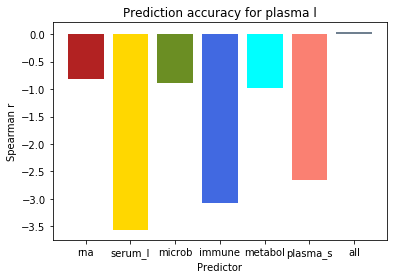

In [81]:
#Plot the results
plt.bar(y_pos, results, color=['firebrick', 'gold', 'olivedrab', 'royalblue', 'cyan', 'salmon', 'slategray'])
plt.xticks(y_pos, predictors)
plt.xlabel('Predictor')
plt.ylabel('Spearman r')
plt.title('Prediction accuracy for plasma l')
plt.show()